<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fpreprocessing-techniques/notebooks/preprocessing_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración para ejecución local y en Google Colab
Este notebook está diseñado para ejecutarse tanto en un entorno local como en Google Colab. A continuación, se incluyen las configuraciones necesarias para ambos entornos.

In [1]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path


# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn tqdm PyEMD pyemd EMD-signal emd PyWavelets acstools
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/notebooks' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation.nc'
print(f"Buscando archivo en: {data_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'ml_precipitation_prediction' already exists and is not an empty directory.
/content/ml_precipitation_prediction
Entorno configurado. Usando ruta base: /content/drive/MyDrive/ml_precipitation_prediction
Buscando archivo en: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation.nc


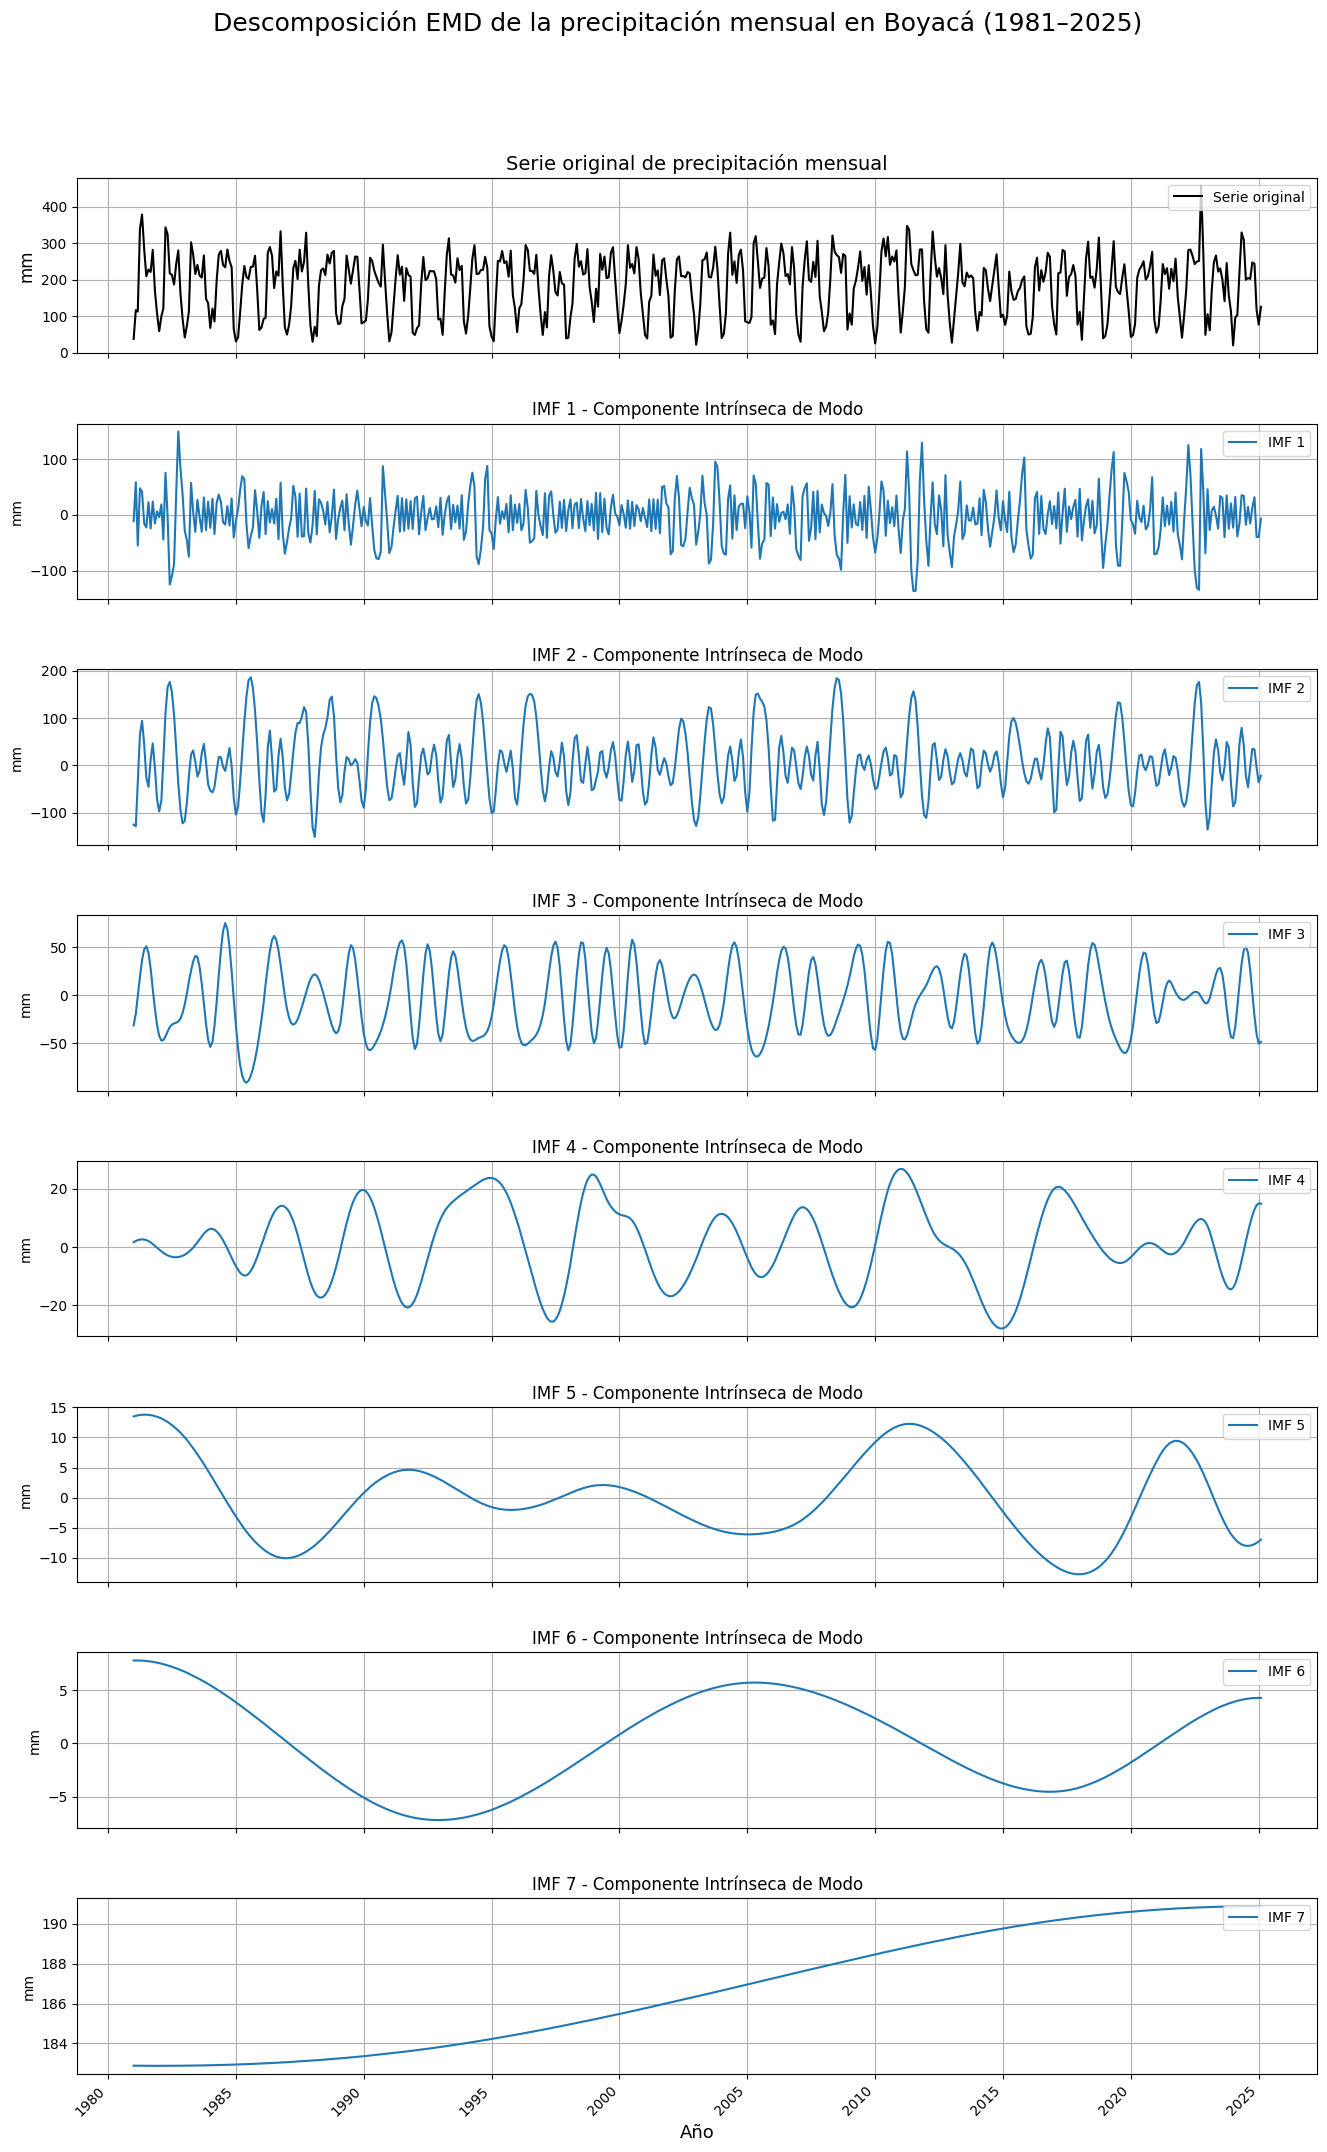

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# 📂 Cargar dataset
ds = xr.open_dataset(data_file)
precip = ds["total_precipitation"]
df = precip.to_dataframe().reset_index()
df["date"] = pd.to_datetime(df["time"])
df_monthly = df.groupby("date")["total_precipitation"].mean().interpolate()

# 🧠 Descomposición EMD
signal = df_monthly.values
emd = EMD()
imfs = emd.emd(signal)

# 🔢 Obtener rango de años
start_year = df_monthly.index.min().year
end_year = df_monthly.index.max().year

# 🎨 Graficar EMD (versión corregida de layout)
fig, axes = plt.subplots(
    imfs.shape[0] + 1, 1,
    figsize=(16, 3 * (imfs.shape[0] + 1)),
    sharex=True
)

# Ponemos el título general un poco más alto
fig.suptitle(
    f"Descomposición EMD de la precipitación mensual en Boyacá ({start_year}–{end_year})",
    fontsize=18,
    y=0.97      # subir el suptitle
)

# Ajustamos espacio vertical entre subplots y arriba
fig.subplots_adjust(
    top=0.90,  # reservamos el 10% superior para el suptitle
    hspace=0.4  # aumentamos el espacio entre filas
)

# --- resto idéntico ---
# Serie original
axes[0].plot(df_monthly.index, signal, color='black', label="Serie original")
axes[0].set_ylabel("mm", fontsize=12)
axes[0].set_title("Serie original de precipitación mensual", fontsize=14)
axes[0].legend(loc="upper right")
axes[0].grid(True)

# IMFs
for i in range(imfs.shape[0]):
    axes[i+1].plot(df_monthly.index, imfs[i], label=f"IMF {i+1}")
    axes[i+1].set_title(f"IMF {i+1} - Componente Intrínseca de Modo", fontsize=12)
    axes[i+1].set_ylabel("mm", fontsize=10)
    axes[i+1].grid(True)
    axes[i+1].legend(loc="upper right")

# Eje de fechas
axes[-1].xaxis.set_major_locator(mdates.YearLocator(base=5))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.xlabel("Año", fontsize=13)
plt.show()


In [ ]:
# ✅ VERSIÓN MODIFICADA DEL CÓDIGO con uso de CHUNKS y resume por archivos ya generados
import warnings
warnings.filterwarnings("ignore")  # Suprimir warnings de pywt u otros

import os
import xarray as xr
import pandas as pd
import numpy as np
from PyEMD import CEEMDAN
from emd import sift  # TVF-EMD
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import acstools as tools
import contextlib
import io

# ----------------------------
# 1. Cargar dataset base
# ----------------------------
DATASET_PATH = data_file
ds = xr.open_dataset(DATASET_PATH)
precip = ds["total_precipitation"]

# ----------------------------
# 2. Estadísticas mensuales
# ----------------------------
time_diffs = np.diff(precip.time.values) / np.timedelta64(1, 'D')
monthly_sum = precip if np.median(time_diffs) > 2 else precip.resample(time='1M').sum(dim='time')

# ----------------------------
# 3. Funciones auxiliares y variables globales
# ----------------------------
latitudes = monthly_sum.latitude.values
longitudes = monthly_sum.longitude.values
ceemdan = CEEMDAN()

def wavelet_energy(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return [np.sum(np.square(c)) for c in coeffs]

def compute_imfs_and_energy(ts, method='CEEMDAN'):
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        imfs = sift.sift(ts, max_imfs=8) if method == 'TVF-EMD' else ceemdan.ceemdan(ts)
    energy_by_imf = [wavelet_energy(imf, level=4) for imf in imfs]
    return imfs, energy_by_imf, len(imfs)

def classify_frequency(row):
    if row['L1'] > max(row['L2'], row['L3'], row['L4'], row['Approx']):
        return 'Alta'
    elif row['L2'] > row['L3'] and row['L2'] > row['Approx']:
        return 'Media'
    else:
        return 'Baja'

# ----------------------------
# 4. Procesamiento por método y por CHUNKS (con resume)
# ----------------------------
def process_method_chunked(method, chunk_latitudes):
    # path de salida basado en método y primer latitud del chunk
    out_fname = f"features_{method.lower()}_chunk_{chunk_latitudes[0]:.6f}.nc"
    out_path = os.path.join(model_output_dir, out_fname)

    # Si ya existe, lo omitimos (resume)
    if os.path.exists(out_path):
        print(f"👀 Ya existe {out_fname}, se omite chunk {chunk_latitudes[0]:.6f}-{chunk_latitudes[-1]:.6f}")
        return out_path

    records = []
    for lat in tqdm(chunk_latitudes, desc=f"{method}"):
        for lon in longitudes:
            ts = monthly_sum.sel(latitude=lat, longitude=lon).values
            if np.any(np.isnan(ts)):
                continue
            imfs, energy, n_modes = compute_imfs_and_energy(ts, method=method)
            for idx, e in enumerate(energy):
                if len(e) < 5:
                    continue
                records.append({
                    'lat': lat, 'lon': lon, 'imf': idx + 1,
                    'L1': e[0], 'L2': e[1], 'L3': e[2], 'L4': e[3], 'Approx': e[4],
                    'n_imfs': n_modes, 'method': method
                })

    df = pd.DataFrame(records)
    df['frecuencia'] = df.apply(classify_frequency, axis=1)

    df_original = ds.to_dataframe().reset_index()
    df_merge = pd.merge(
        df, df_original,
        how='left',
        left_on=['lat', 'lon'],
        right_on=['latitude', 'longitude']
    )

    # Eliminar duplicados exactos
    df_merge = df_merge.drop_duplicates(subset=["lat", "lon", "imf"])
    # Verificar índice único
    if df_merge.duplicated(subset=["lat", "lon", "imf"]).any():
        raise ValueError("Hay duplicados en el índice (lat, lon, imf) incluso después de deduplicar.")

    df_merge["imf"] = df_merge["imf"].astype(int)
    ds_out = df_merge.set_index(["lat", "lon", "imf"]).to_xarray()

    ds_out.to_netcdf(out_path)
    print(f"✅ Chunk {chunk_latitudes[0]:.6f}-{chunk_latitudes[-1]:.6f} guardado en: {out_fname}")
    return out_path

# ----------------------------
# 5. Ejecutar procesamiento secuencial por chunks
# ----------------------------
from numpy import array_split

chunks = array_split(latitudes, 4)  # Dividir en 4 partes (ajustable)

for method in ['CEEMDAN', 'TVF-EMD']:
    for chunk in chunks:
        process_method_chunked(method, chunk)


CEEMDAN: 100%|██████████| 16/16 [58:25<00:00, 219.10s/it]


✅ Chunk 4.375000-5.125000 guardado en: features_ceemdan_chunk_4.375000.nc
👀 Ya existe features_ceemdan_chunk_5.174999.nc, se omite chunk 5.174999-5.875000
👀 Ya existe features_ceemdan_chunk_5.924999.nc, se omite chunk 5.924999-6.625000


CEEMDAN: 100%|██████████| 15/15 [55:14<00:00, 220.98s/it]


✅ Chunk 6.674999-7.375000 guardado en: features_ceemdan_chunk_6.674999.nc


TVF-EMD: 100%|██████████| 16/16 [00:31<00:00,  1.97s/it]
